##Part 3 : Autoencoders 

In this part we train different models of autoencoders.We  user movielens 1 million dataset.We implement single hidder layer AE,deep AE and deep AE with weights tying with different activation layers.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import ndcg_score
import sys
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.optimizers import Adam
from IPython.display import display


root_path='/content/drive/My Drive/ml-dataset'

###load movies.dat
movies = pd.read_csv(root_path+"/movies.dat",sep='::',header=None)
movies=movies.rename(columns= {0:'movieId',1:'Title',2:'Genre'})

### load extracted dataset features
x = np.load(root_path+ '/dataset.npy')
movieId=np.load(root_path+ '/movieId.npy')

###split dataset
X_train, X_test= train_test_split(x,  test_size=0.10)
X_train, X_val= train_test_split(X_train,  test_size=0.15)

print(' x train ' ,X_train.shape)
print(' x val ' ,X_val.shape)
print(' x test ' ,X_test.shape)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


 x train  (4620, 3706)
 x val  (816, 3706)
 x test  (604, 3706)


In [0]:

### single hidden  layer
def get_model_single(encoding_dim=256,input_dim=3706,activation="sigmoid"):
       
    input_layer = Input(shape=(input_dim,))
    
    encoded = Dense(encoding_dim, activation=activation, activity_regularizer=regularizers.l1(10e-5))(input_layer)    
    decoded = Dense(input_dim, activation=activation)(encoded)    
  
    autoencoder_single = Model(input_layer, decoded)
  
    autoencoder_single.summary()

    return autoencoder_single

### tied wieghts deep model
def get_model_tied(activation1,activation2,input_dim=3706):

  dense_1 = keras.layers.Dense(1024,input_shape=(input_dim,), activation=activation1)
  dense_2 = keras.layers.Dense(512, activation=activation1)
  dense_3 = keras.layers.Dense(256, activation=activation1)
  dense_4 = keras.layers.Dense(128, activation=activation1)

  tied_encoder = keras.models.Sequential([
      
      dense_1,
      dense_2,
      dense_3,
      dense_4
  ])

  tied_decoder = keras.models.Sequential([
      DenseTranspose(dense_4, activation=activation1),
      DenseTranspose(dense_3, activation=activation1),
      DenseTranspose(dense_2, activation=activation1),
      DenseTranspose(dense_1, activation=activation2),
  
  ])


  model = keras.models.Sequential([tied_encoder, tied_decoder])
  model.summary()
  
  return model

### deep AE model
def get_model(activation1,activation2,input_dim=3706):

  dense_1 = keras.layers.Dense(1024, input_shape=(input_dim,), activation="selu")
  dense_2 = keras.layers.Dense(512, activation="selu")
  dense_3 = keras.layers.Dense(256, activation="selu")
  dense_4 = keras.layers.Dense(128, activation="selu")

  tied_encoder = keras.models.Sequential([
      dense_1,
      dense_2,
      dense_3,
      dense_4
  ])

  tied_decoder = keras.models.Sequential([
      keras.layers.Dense(256, activation="selu"),
      keras.layers.Dense(512, activation="selu"),
      keras.layers.Dense(1027, activation="selu"),
      keras.layers.Dense(input_dim, activation="sigmoid"),
      
  ])

  model = keras.models.Sequential([tied_encoder, tied_decoder])
  model.summary()
  
  return model


##plotting
def plothistory(h,title, metric='mean_squared_error',):
    
    
    if metric == 'acc':
        plt.title('accuracy')
    else:
        plt.title(title+ metric)

    plt.plot(h.history['loss'] ,label='train ')
    plt.plot(h.history['val_loss'],label='validation')

    #plt.plot(h.history['val_'+metric], label='validation')
    #plt.plot(h.history[metric], label='train')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')



def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
  


###train given model
def train_model(model,epochs,loss='mean_squared_error'):
  session = keras.backend.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  model.compile(optimizer='adam', loss=loss,metrics=['mae'])

  history=model.fit(X_train, X_train,epochs=epochs,
                  batch_size=512,
                  shuffle=True,
                  validation_data=(X_val, X_val))
  
  return history,model

In [0]:
## @source : Géron ,Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow


### weight tying
class DenseTranspose(keras.layers.Layer):


  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",
    shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

##Training
We train 5 different configurations of autoencoder :
1.   Single hidden layer
2.   Deep AE ,with sigmoid activation
3. Deep AE with weight tying,linear activation
4. Deep AE with weight tying,sigmoid activation
5. Deep AE with weight tying,tanh activation

Training all models below.





In [0]:
modelMaps=dict.fromkeys(['single','deep_sigmoid','tied_linear','tied_sigmoid','tied_tanh' ])

modelMaps['single']=get_model_single()   
modelMaps['deep_sigmoid']=get_model("selu","sigmoid")
modelMaps['tied_linear']=get_model_tied("relu","linear")
modelMaps['tied_sigmoid']=get_model_tied("selu","sigmoid")
modelMaps['tied_tanh']=get_model_tied("selu","tanh")


####train the models
history={}
trainedModels={}
for k in modelMaps.keys():
   history[k],trainedModels[k]= train_model(modelMaps.get(k) ,200 )




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3706)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               948992    
_________________________________________________________________
dense_2 (Dense)              (None, 3706)              952442    
Total params: 1,901,434
Trainable params: 1,901,434
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)       

## Plot training and validation loss


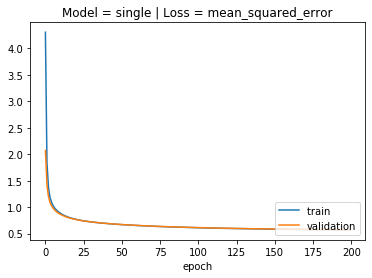

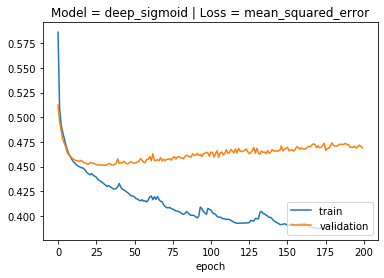

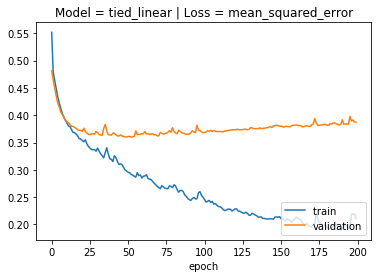

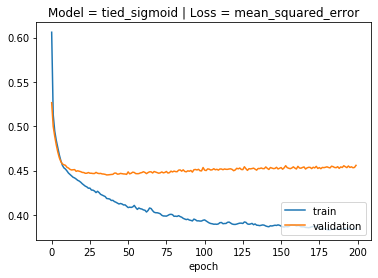

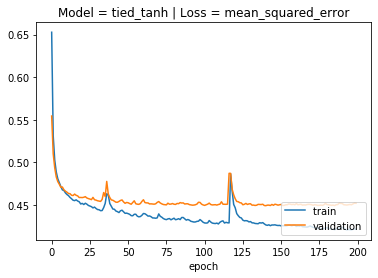

In [0]:
  

##plot histories
title='Model = '
for k in history.keys():
    v=history.get(k)
    
    plothistory(v,title+str(k)+" | Loss = ")
    plt.show()

In [0]:
 

def get_max_ratings( arr, count=None):

  top=np.sort(np.unique(arr))[::-1] [:count] 
  
  #top=np.sort(arr)[::-1] [:count] 
  #print('top ',top)
  a=np.where(arr==top[:,None])
  #print(a[0])
  #print(a[1])
  r=a[1][:count]
  #print)
  return r


###sort whole dataset
def get_maxratings_dataset( arr, count=None):
  sorted=[]
  movies=[]
  for i in arr:
    u=get_max_ratings(i,count)
    m=movieId[u]
    sorted.append(u)
    movies.append(m)
  return np.asarray(sorted),np.asarray(movies)

###get movies 
def get_movies(numberRatings,user,data):    
    
    u=data[user,:]    
    a=get_max_ratings(u,numberRatings)    
    #print(len(list(set(a))))
    movie_rating=movieId[a]
    #print('movied id' ,( ))
    return movie_rating


    

### do predictions on test set
mseMap={}
maeMap={}
rmseMap={}


def do_predictions(testset):
    
    predictionMap={}
    for k in trainedModels.keys():
        
        m=trainedModels.get(k)
        prediction=m.predict(testset)
        predictionMap[k]=prediction
        print('#### Loss| Model =',k )
        print()
        mse=np.round(MSE(testset, prediction),4)
        mae=np.round(MAE(testset, prediction),4)
        rmse=np.round(np.sqrt(mse),4)
        print('Mean Square Error :',mse)
        print('Mean Absolute Error :',mae)
        print('Root Mean Square Error :',rmse)
        print()
   
        mseMap[k]=mse
        maeMap[k]=mae
        rmseMap[k]=rmse
        
        
    return predictionMap

## Evaluation 

We evaluate the trained models on test set.We use mainly 3 metrics :
* Root Mean Square Error (RMSE)
* Mean Absolute Error (MAE)
* Normalized Discounted Cumulative Gain (NDCG)




In [0]:
    
predictionMap=do_predictions(X_test)


#### Loss| Model = single

Mean Square Error : 0.5619
Mean Absolute Error : 0.3766
Root Mean Square Error : 0.7496

#### Loss| Model = deep_sigmoid

Mean Square Error : 0.7318
Mean Absolute Error : 0.6156
Root Mean Square Error : 0.8555

#### Loss| Model = tied_linear

Mean Square Error : 0.6325
Mean Absolute Error : 0.2132
Root Mean Square Error : 0.7953

#### Loss| Model = tied_sigmoid

Mean Square Error : 0.7148
Mean Absolute Error : 0.6116
Root Mean Square Error : 0.8455

#### Loss| Model = tied_tanh

Mean Square Error : 0.4515
Mean Absolute Error : 0.2473
Root Mean Square Error : 0.6719



In [0]:
### get ndcg scores on sorted movie ratings

ndcgMap={}
def ndcgScores(predictmap,trueMovieSorted,k=100):

    
    for i in predictmap.keys():
        predict=predictmap.get(i)
        index,predMovieId=get_maxratings_dataset(predict,count=k)
        score=ndcg_score(trueMovieSorted, predMovieId)
        ndcgMap[i]=np.round(score,4)

        print("NDCG score | Model "+i + " :"+str(np.round(score,4)))
        
    return ndcgMap
        
        


sortedIndex,trueMovieSorted=get_maxratings_dataset(X_test,count=100)

ndcgMap=ndcgScores(predictionMap,trueMovieSorted,100)


NDCG score | Model single :0.8341
NDCG score | Model deep_sigmoid :0.8354
NDCG score | Model tied_linear :0.8318
NDCG score | Model tied_sigmoid :0.8334
NDCG score | Model tied_tanh :0.8339


## Results summary table



In [0]:

####PLot results table
from prettytable import PrettyTable
keys=rmseMap.keys()
header=['Metric']
rmseRow=['Root Mean Squared Error']
mseRow=['Mean Squared Error']
maeRow=['Mean Absolute Error']
ndcgRow=['Normalised Discounted Cumulative Gain']

for k in rmseMap.keys():
  header.append(k)
  rmseRow.append(rmseMap.get(k))
  mseRow.append(mseMap.get(k))
  maeRow.append(maeMap.get(k))
  ndcgRow.append(ndcgMap.get(k))

#print('++++++++++++++++ Results Metrics Summary ++++++++++++++++')

t = PrettyTable()
t.field_names =header
t.title="Results Metrics Summary"
t.add_row(rmseRow)
t.add_row(mseRow)
t.add_row(maeRow)
t.add_row(ndcgRow)

print(t)


+---------------------------------------+--------+--------------+-------------+--------------+-----------+
|                 Metric                | single | deep_sigmoid | tied_linear | tied_sigmoid | tied_tanh |
+---------------------------------------+--------+--------------+-------------+--------------+-----------+
|        Root Mean Squared Error        | 0.7496 |    0.8555    |    0.7953   |    0.8455    |   0.6719  |
|           Mean Squared Error          | 0.5619 |    0.7318    |    0.6325   |    0.7148    |   0.4515  |
|          Mean Absolute Error          | 0.3766 |    0.6156    |    0.2132   |    0.6116    |   0.2473  |
| Normalised Discounted Cumulative Gain | 0.8341 |    0.8354    |    0.8318   |    0.8334    |   0.8339  |
+---------------------------------------+--------+--------------+-------------+--------------+-----------+


## Visualize Predictions
We display the movies recommended based on the predicted ratings.

In [0]:

def displayMovies(ratings):
    
    df=movies.loc[movies['movieId'].isin( ratings)].sort_values(by=['movieId'])
    #print(df.count)
    return df
    

In [0]:

numberRatings=20
user=51

predictSingle=predictionMap["single"]
predictTied=predictionMap["tied_tanh"]
predictLinear=predictionMap["tied_linear"]

org_rating=get_movies(numberRatings,user,X_test)
ratings_tied=get_movies(numberRatings,user,predictTied)
ratings_single=get_movies(numberRatings,user,predictSingle)
ratings_linear=get_movies(numberRatings,user,predictLinear)

In [0]:

print('######### Original movie ratings ###########')
print()

df=displayMovies(org_rating)
display(df)

######### Original movie ratings ###########


,movieId,Title,Genre
46,47,Seven (Se7en) (1995),Crime|Thriller
49,50,"Usual Suspects, The (1995)",Crime|Thriller
160,162,Crumb (1994),Documentary
174,176,Living in Oblivion (1995),Comedy
192,194,Smoke (1995),Drama
293,296,Pulp Fiction (1994),Crime|Drama
497,501,Naked (1993),Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
604,608,Fargo (1996),Crime|Drama|Thriller
1120,1136,Monty Python and the Holy Grail (1974),Comedy


In [0]:

print('############# Predicted movie ratings-Single layer Model #############')
print()
displayMovies(ratings_single)

############# Predicted movie ratings-Single layer Model #############



,movieId,Title,Genre
108,110,Braveheart (1995),Action|Drama|War
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
315,318,"Shawshank Redemption, The (1994)",Drama
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
523,527,Schindler's List (1993),Drama|War
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
604,608,Fargo (1996),Crime|Drama|Thriller
847,858,"Godfather, The (1972)",Action|Crime|Drama
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War


In [0]:
print('######### predicted movie ratings-Linear layer Model ############## ')
print()
displayMovies(ratings_linear)

######### predicted movie ratings-Linear layer Model ############## 



,movieId,Title,Genre
129,131,Frankie Starlight (1995),Drama|Romance
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
1062,1078,Bananas (1971),Comedy|War
1432,1459,Absolute Power (1997),Mystery|Thriller
1543,1584,Contact (1997),Drama|Sci-Fi
1603,1649,"Fast, Cheap & Out of Control (1997)",Documentary
1732,1792,U.S. Marshalls (1998),Action|Thriller
1906,1975,Friday the 13th Part 2 (1981),Horror
1958,2027,Mafia! (1998),Comedy|Crime
2022,2091,Return from Witch Mountain (1978),Children's|Sci-Fi


In [0]:

print('########### Predicted movie ratings-Tied Model @ Tanh ############')
print()
displayMovies(ratings_tied)

########### Predicted movie ratings-Tied Model @ Tanh ############



,movieId,Title,Genre
24,25,Leaving Las Vegas (1995),Drama|Romance
220,223,Clerks (1994),Comedy
293,296,Pulp Fiction (1994),Crime|Drama
604,608,Fargo (1996),Crime|Drama|Thriller
1195,1213,GoodFellas (1990),Crime|Drama
1245,1265,Groundhog Day (1993),Comedy|Romance
1250,1270,Back to the Future (1985),Comedy|Sci-Fi
1595,1641,"Full Monty, The (1997)",Comedy
1627,1673,Boogie Nights (1997),Drama
1683,1732,"Big Lebowski, The (1998)",Comedy|Crime|Mystery|Thriller


## Conclusions and Discussions

We compared different machine learning algorithms which can be used for collaborative filtering movie recommendations.From our comparions between models,we observed that autoencoder with tanh activation at output layer along with tied weights had the lowest RMSE of 0.67.Its loss is also lower than that of the spark ALS algorithm which is 0.81 and trained on 20 million ratings ,whereas the autoencoders where trained only on 1 million ratings.
From the predictions of ratings,we observe that even thought the loss of single hidden layer AE is comparitive low,its predicted movie ratings do not change very much per user,which can suggest overfitting of the model to the highest rated movies.Whereas in case of deep AE models with tied weights,the model was capabale of predicting diverse movie ratings based on the user.THis is important of in collaborative filtering methods of recommendations,where the recommedations happen based on personalised users than just the highest rated items.

Further,we can train more complex autoencoder models on bigger dataset like 20 million ratings.

Based on the results ,we can infer that autoencoders can be applied to collaborative filtering recommendation systems.

## References


1.   Sedhain, Suvash, Aditya Menon, Scott Sanner, and Lexing Xie. “AutoRec: Autoencoders Meet Collaborative Filtering,” 111–12, 2015. https://doi.org/10.1145/2740908.2742726.

2.  “Deep Learning Based Recommender System: A Survey and New Perspectives.” Accessed January 14, 2020. https://arxiv.org/abs/1707.07435.

3. Lund, Jeffrey, and Yiu-Kai Ng. “Movie Recommendations Using the Deep Learning Approach.” In 2018 IEEE International Conference on Information Reuse and Integration (IRI), 47–54, 2018. https://doi.org/10.1109/IRI.2018.00015.

4. “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition [Book].” Accessed January 14, 2020. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/.

5. Kuchaiev, Oleksii, and Boris Ginsburg. “Training Deep AutoEncoders for Collaborative Filtering.” ArXiv:1708.01715 [Cs, Stat], October 10, 2017. http://arxiv.org/abs/1708.01715.



 

